In [1]:
import datetime as dt
import numpy as np
import xarray as xr

import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
import pandas as pd
from dateutil.relativedelta import relativedelta
import cartopy.crs as ccrs
import scipy as sp
import xarray_regrid
import subprocess

# Load data

In [2]:
#target_grid = xr.open_dataset('data/spi3_cmap_1x1.nc')
#rename lat and lon to match the data
#target_grid = target_grid.rename({'latitude':'Y', 'longitude':'X'})
#target_grid = target_grid.sel(X = slice(32, 60), Y = slice(37, 12))

## NMME

In [3]:
#make a download directory
import os
if not os.path.exists('download'):
    os.makedirs('download')


In [4]:
download = True

In [5]:
cfsv2_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NCEP-CFSv2/.HINDCAST/.PENTAD_SAMPLES_FULL/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
cfsv2_path = 'download/cfsv2_precip.nc'

gfdlspear_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.GFDL-SPEAR/.HINDCAST/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
gfdlspear_path = 'download/gfdlspear_precip.nc'

cansipsic4_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.CanSIPS-IC4/.HINDCAST/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
cansipsic4_path = 'download/cansipsic4_precip.nc'

if download:
    print(cfsv2_url)
    subprocess.call(['curl', '-b', 'cookies.txt', '-k', cfsv2_url, '-o', cfsv2_path])
    print(gfdlspear_url)
    subprocess.call(['curl', '-b', 'cookies.txt', '-k', gfdlspear_url, '-o', gfdlspear_path])
    print(cansipsic4_url)
    subprocess.call(['curl', '-b', 'cookies.txt', '-k', cansipsic4_url, '-o', cansipsic4_path])
    


https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NCEP-CFSv2/.HINDCAST/.PENTAD_SAMPLES_FULL/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc
https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.GFDL-SPEAR/.HINDCAST/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc
https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.CanSIPS-IC4/.HINDCAST/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc


In [7]:
cfsv2 = xr.open_dataset(cfsv2_path, decode_times=True)
cfsv2 = cfsv2.rename({'S':'T'})

gfdlspear = xr.open_dataset(gfdlspear_path, decode_times=True)
gfdlspear = gfdlspear.rename({'S':'T'})

cansipsic4 = xr.open_dataset(cansipsic4_path, decode_times=True)
cansipsic4 = cansipsic4.rename({'S':'T'})


FileNotFoundError: [Errno 2] No such file or directory: 'c:\\git\\KAUSTgithub\\download\\cansipsic4_precip.nc'

## Obs

In [ ]:
obs = xr.open_dataset('data/precip_cmap.nc', decode_times=True)

obs = obs.swap_dims({'time': 'T', 'lon': 'X', 'lat': 'Y'})
obs = obs.assign_coords(T=obs.time, X=obs.lon, Y=obs.lat)
obs = obs.drop(['time', 'lat', 'lon'])
obs = obs.sel(X=slice(30, 64), Y=slice(40, 10))
obs = obs.transpose('T', 'Y', 'X')

target_grid = cfsv2
data_regrid = obs.interp(X=target_grid['X'], Y=target_grid['Y'])
#replace all negative values with 0
data_regrid['precip'] = data_regrid['precip'].where(data_regrid['precip'] > 0, 0)

obs = data_regrid

obs = obs*30
obs['rolling_sum'] = obs['precip'] + obs['precip'].shift(T=-1) + obs['precip'].shift(T=-2)


obs = obs.rolling_sum.dropna('T')

C:\Users\emile\AppData\Local\Temp\ipykernel_14880\802494714.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  obs = obs.drop(['time', 'lat', 'lon'])


# Forecast

In [ ]:
nmme_dict =  {'cfsv2': cfsv2, 'gfdlspear': gfdlspear, 'cansipsic4': cansipsic4}

precip_fcast_dict = {'cfsv2': None, 'gfdlspear': None, 'cansipsic4': None}
spi_fcast_dict = {'cfsv2': None, 'gfdlspear': None, 'cansipsic4': None}

In [ ]:
for (nmme_name, nmme) in nmme_dict.items():
    print(f"######################")
    print(f"Processing NMME model {nmme_name}")
    print(f"######################")
    P_bar_all = nmme.mean(dim='M')['prec']
    P_bar = P_bar_all.sel(L=slice(0.5, 2.5)).mean(dim='L')

    # Ensure 'T' is converted to datetime if not already
    P_bar['T'] = pd.to_datetime(P_bar['T'].values)
    obs['T'] = pd.to_datetime(obs['T'].values)

    P_bar = P_bar.sel(T=slice('1991-01-01','2020-12-31'))

    spi_list = []
    precip_list = []

    for month in range(1, 2):
        print(f"Processing month: {month}")
        # Prepare storage for SPI values
        x_range = P_bar['X'].values
        y_range = P_bar['Y'].values
        fcast_periods = P_bar['T'].values
    

        # Select data for the current month
        P_bar_month = P_bar.sel(T=P_bar['T.month'] == month)
        obs_month = obs.sel(T=obs['T.month'] == month)

        spi_storage = np.full((len(P_bar_month), len(y_range), len(x_range)), np.nan)
        P_storage = np.full((len(P_bar_month), len(y_range), len(x_range)), np.nan)
        
        # # Compute climatology and anomalies
        # P_c = P_bar_month.rolling(T=1).mean().dropna(dim='T')
        # P_a = P_bar_month - P_c
        
        # obs_climo = obs_month.rolling(T=20).mean().dropna(dim='T')
        
        # P_fcst = P_a + obs_climo
        fcast_years = P_bar_month['T'].values
        
        # Iterate over each forecast year
        for y in range(0,len(fcast_years)):

            # Compute climatology and anomalies
            #remove year y and compute the climatology
            P_c = P_bar_month.where(P_bar_month['T'] != fcast_years[y]).mean(dim='T')
            P_a = P_bar_month - P_c
            
            fcast_year = fcast_years[y].astype('datetime64[s]').item() 
            ty_1 = fcast_year- relativedelta(years=1)
            ty_30 = fcast_year- relativedelta(years=30)
            obs_climo = obs_month.sel(T=slice(ty_30, ty_1)).mean(dim='T')
            
            P_fcst = P_a + obs_climo

            P_fcst_y = P_fcst.sel(T=fcast_year)

            P_storage[y] = P_fcst_y.values
            
            # Retrieve all observations before the current time step
            obs_y = obs_month.sel(T=slice(ty_30, ty_1)) 
            
            # Append the current forecast value to observations and sort
            obs_y_combined = xr.concat([obs_y, P_fcst_y], dim='T').sortby('T')
            
            # Compute SPI for the current time step
            print(f"Computing SPI for month: {month}, year: {y+1}")
            
            for i in range(len(y_range)):
                for j in range(len(x_range)):
                    data_grid = obs_y_combined.sel(X=x_range[j], Y=y_range[i]).values
                    
                    if np.all(np.isnan(data_grid)):  # Skip if all values are NaN
                        continue
                    
                    # Fit Pearson Type III distribution
                    try:
                        a, loc, scale = sp.stats.pearson3.fit(data_grid)
                        cdf_values = sp.stats.pearson3.cdf(data_grid, skew=a, loc=loc, scale=scale)
                        
                        # Handle zero-inflated data
                        q = np.sum(data_grid == 0) / len(data_grid)
                        cdf_values = (cdf_values * (1 - q)) + q
                        
                        # Ensure CDF is within valid bounds
                        cdf_values = np.clip(cdf_values, 1e-6, 1 - 1e-6)
                        
                        # Convert CDF to SPI
                        spi_time_series = sp.stats.norm.ppf(cdf_values)
                        spi_storage[y, i, j] = spi_time_series[-1]
                    except Exception as e:
                        print(f"Error fitting distribution at (X={x_range[j]}, Y={y_range[i]}): {e}")
        
        # Convert SPI storage to xarray DataArray for the current month
        spi_month = xr.DataArray(
            spi_storage,
            dims=['T', 'Y', 'X'],
            coords={'T': P_fcst['T'], 'Y': y_range, 'X': x_range}
        )
        
        spi_list.append(spi_month)

        P_month = xr.DataArray(
            P_storage,
            dims=['T', 'Y', 'X'],
            coords={'T': P_fcst['T'], 'Y': y_range, 'X': x_range}
        )

        precip_list.append(P_month)

    # Concatenate SPI results across all months and sort by time
    spi_fcast = xr.concat(spi_list, dim='T').sortby('T')
    precip_fcast = xr.concat(precip_list, dim='T').sortby('T')

    precip_fcast_dict[nmme_name] = precip_fcast
    spi_fcast_dict[nmme_name] = spi_fcast

    spi_fcast.to_netcdf(f'data/spi_fcast_{nmme_name}.nc')
    precip_fcast.to_netcdf(f'data/precip_fcast_{nmme_name}.nc')

SyntaxError: '(' was never closed (3794437428.py, line 3)

# Skill

In [ ]:
spi_obs = xr.load_dataset('data/spi3_cmap_1x1.nc')
#rename variable __xarray_dataarray_variable__ to spi
spi_obs = spi_obs.rename({'__xarray_dataarray_variable__':'spi'}).spi.sortby('T')

In [ ]:
#compute corr map between obs and spi

corr_ds = xr.Dataset()
#loop over each nmmme
for nmme_name in ['cfsv2', 'gfdlspear', 'cansipsic4']:
    precip_fcast = xr.open_dataset(f'data/precip_fcast_{nmme_name}.nc')
    precip_fcast = precip_fcast.rename({'__xarray_dataarray_variable__':'precip'}).precip

    spi_fcast = xr.open_dataset(f'data/spi_fcast_{nmme_name}.nc')
    spi_fcast = spi_fcast.rename({'__xarray_dataarray_variable__':'spi'}).spi

    precip_fcast = precip_fcast.sel(T=spi_fcast['T'])
    spi_fcast = spi_fcast.sel(T=precip_fcast['T'])

    # Loop over each month
    for month in range(1, 2):  # Months 1 to 12
        # Select data for the specific month
        spi_obs_m = spi_obs.sel(T=spi_obs['T.month'] == month)
        precip_obs_m = obs.sel(T=obs['T.month'] == month)
        spi_fcast_m = spi_fcast.sel(T=spi_fcast['T.month'] == month)
        precip_fcast_m = precip_fcast.sel(T=precip_fcast['T.month'] == month)

        #match all the time steps
        spi_obs_m = spi_obs_m.sel(T=spi_fcast_m['T'])
        precip_obs_m = precip_obs_m.sel(T=spi_fcast_m['T'])
        precip_fcast_m = precip_fcast_m.sel(T=spi_fcast_m['T'])


        # Compute correlations for each pair of variables using xarray's corr method
        corr_precip = xr.corr(precip_obs_m, precip_fcast_m, dim='T')
        corr_spi = xr.corr(spi_obs_m, spi_fcast_m, dim='T')


        corr_ds[f'corr_{nmme_name}_precip_month_{month}']  =  corr_precip
        corr_ds[f'corr_{nmme_name}_spi_month_{month}']  =  corr_spi


# Plot 

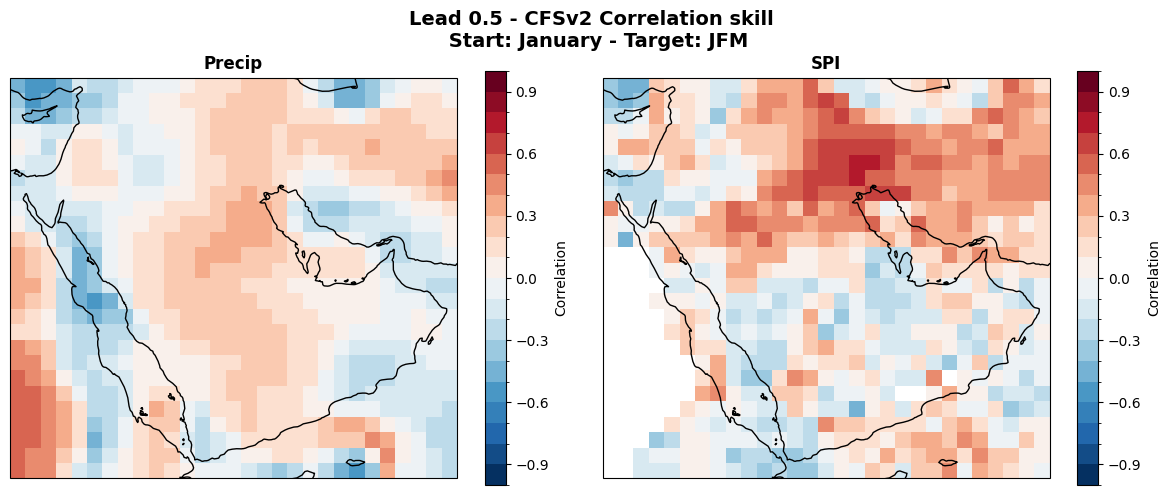

KeyError: "No variable named 'corr_precip_month_2'. Variables on the dataset include ['X', 'Y', 'corr_precip_month_1', 'corr_spi_month_1']"

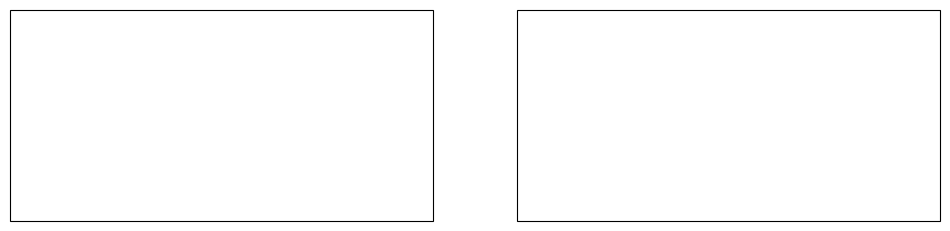

In [ ]:
levels = [-1, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
season_names = ['JFM', 'FMA', 'MAM', 'AMJ', 'MJJ', 'JJA', 'JAS', 'ASO', 'SON', 'OND', 'NDJ']
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for nmme_name in ['cfsv2', 'gfdlspear', 'cansipsic4']:
    for season in range(1, 13):
        season_name = season_names[season-1]
        month_name = month_names[season-1]
        
        fig, axes = plt.subplots(
            nrows=1, ncols=2, figsize=(12, 5), subplot_kw={'projection': ccrs.PlateCarree()}
        )
        
        # Plot corr_obs_month
        corr_map_obs = corr_ds[f'corr_{nmme_name}_precip_month_{season}']
        corr_map_obs.plot(
            vmin=-1, vmax=1, cmap='RdBu_r', cbar_kwargs={'label': 'Correlation'}, ax=axes[0],
            levels=levels
        )
        axes[0].coastlines()
        axes[0].set_title('Precip Correlation', fontsize=12, fontweight='bold')
        
        # Plot corr_spi_month
        corr_map_spi = corr_ds[f'corr_{nmme_name}_spi_month_{season}']
        corr_map_spi.plot(
            vmin=-1, vmax=1, cmap='RdBu_r', cbar_kwargs={'label': 'Correlation'}, ax=axes[1],
            levels=levels
        )
        axes[1].coastlines()
        axes[1].set_title('SPI Correlation', fontsize=12, fontweight='bold')
        
        # Set overall figure title
        nmme_name_caps = nmme_name.upper()
        fig.suptitle(f'Lead 0.5 - {nmme_name_caps} \n Start: {month_name} - Target: {season_name}',
                      fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()